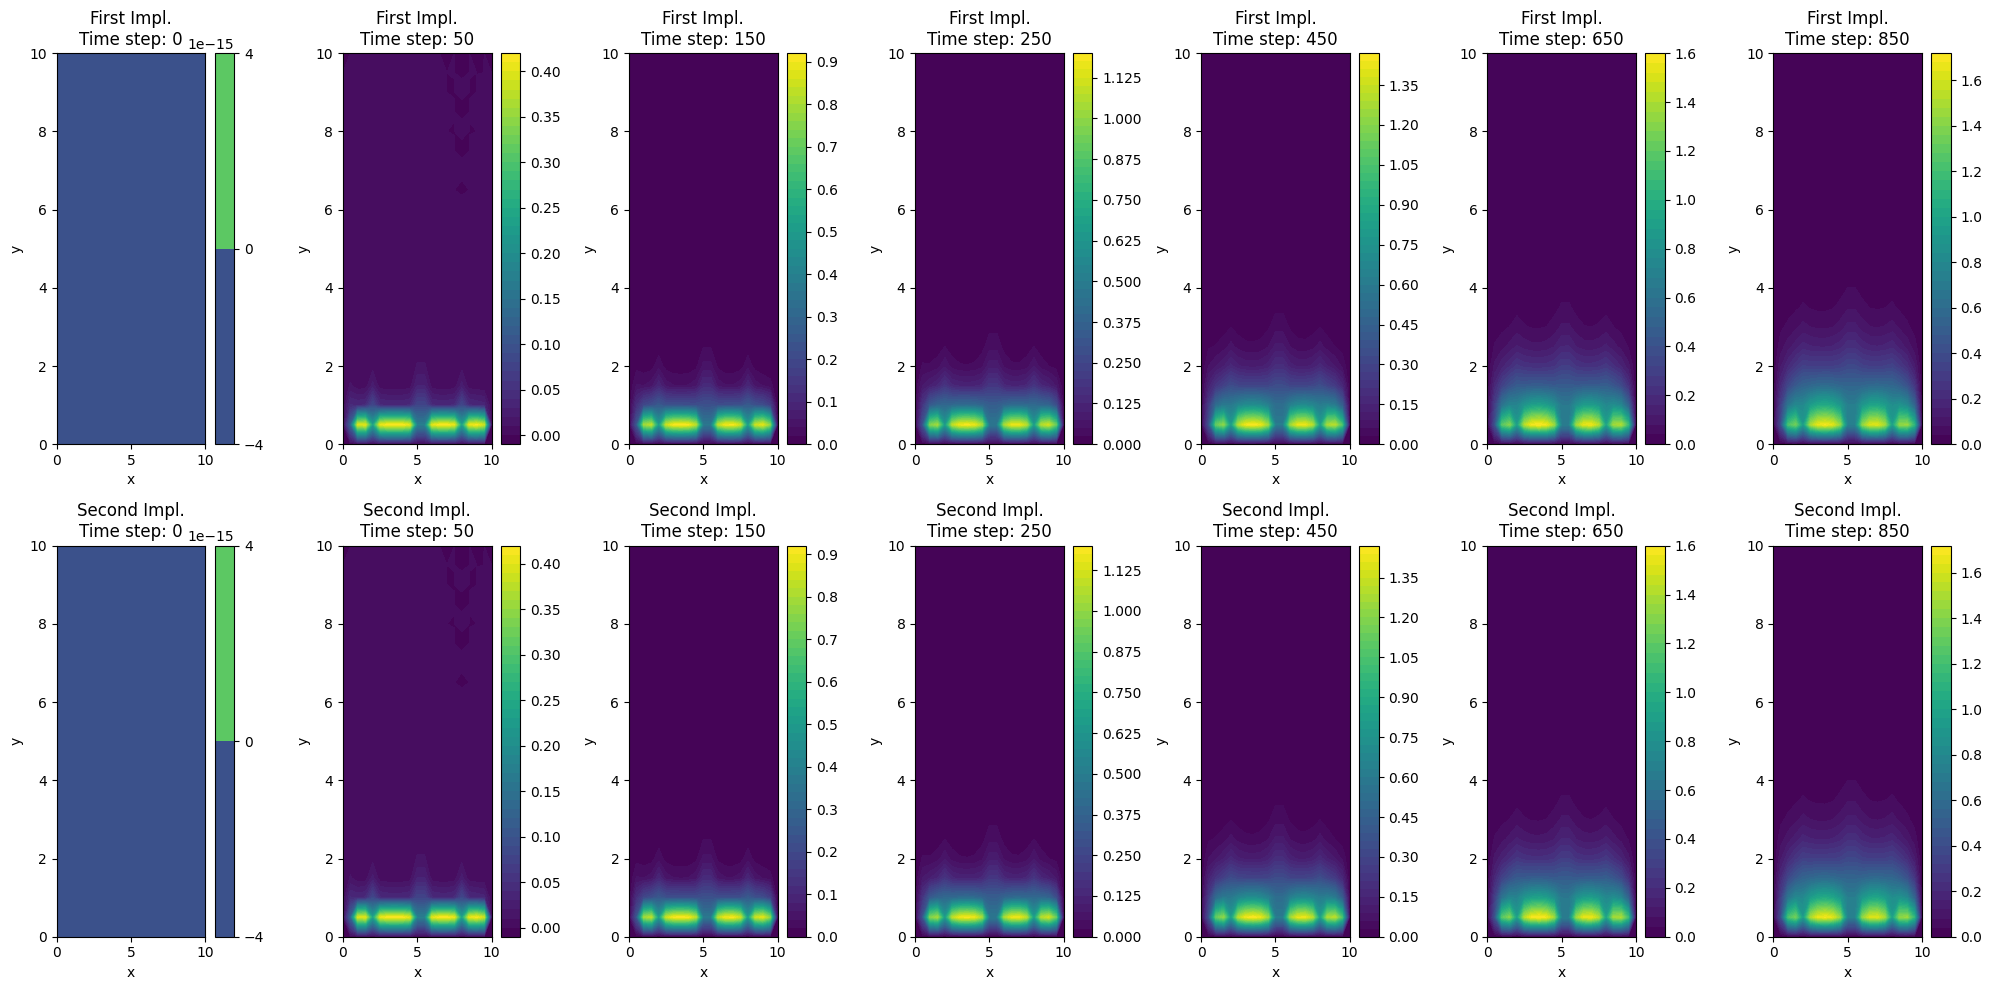

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Задаем параметры
Lx, Ly = 10, 10  # Размеры области
Nx, Ny = 21, 21  # Количество узлов в сетке
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Шаг сетки
dt = 0.1  # Шаг по времени
total_time = 85  # Общее время моделирования
Nt = int(total_time / dt)  # Количество временных шагов

# Координаты сетки
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Инициализация поля концентрации
u = np.zeros((Ny, Nx))


D = np.zeros((Ny, Nx))
D[(X >= 0.25) & (X < 1)] = 0.5
D[(X >= 2) & (X < 2.5)] = 0.7
D[(X >= 5) & (X < 6)] = 0.5
D[(X >= 8) & (X < 8.5)] = 0.8
D[D == 0] = 0.01

# Источник вещества
S = np.zeros((Ny, Nx))
S[Y <= 0.5] = 0.1

# Создаем список для хранения временных шагов
u_list_first = [u.copy()]

def update(frame):
    global u
    u_new = u.copy()
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            u_new[j, i] = u[j, i] + dt * (
                D[j, i] * (
                    (u[j, i+1] - 2*u[j, i] + u[j, i-1]) / dx**2 +
                    (u[j+1, i] - 2*u[j, i] + u[j-1, i]) / dy**2
                ) + S[j, i]
            )
    u = u_new
    u_list_first.append(u.copy())

# Выполнение расчета без анимации
for frame in range(Nt):
    update(frame)

# Конечное состояние для первой реализации
u_final_first = u_list_first[-1]

# Вторая реализация
def initiate_system(delta_x: float, delta_y: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X = np.arange(0, 10 + delta_x, delta_x)
    Y = np.arange(0, 10 + delta_y, delta_y)

    u = np.zeros((Y.size, X.size), dtype=float)
    S = np.zeros((Y.size, X.size), dtype=float)
    D = np.zeros((Y.size, X.size), dtype=float)

    for j, x in enumerate(X):
        for i, y in enumerate(Y):
            if y <= 0.5:
                S[i, j] = 0.1

            if 0.25 <= x < 1:
                D[i, j] = 0.5
            elif 2 <= x < 2.5:
                D[i, j] = 0.7
            elif 5 <= x < 6:
                D[i, j] = 0.5
            elif 8 <= x < 8.5:
                D[i, j] = 0.8
            else:
                D[i, j] = 0.01

    return u, S, D, X, Y

def solve(u, S, D, delta_x, delta_y, delta_t):
    u_next = np.zeros(u.shape)

    for i in range(1, u.shape[0] - 1):
        for j in range(1, u.shape[1] - 1):
            # Расчет концентрации на следующем шаге с учетом всех членов уравнения
            u_next[i, j] = u[i, j] + D[i, j] * delta_t * (
                (u[i+1, j] - 2*u[i, j] + u[i-1, j]) / delta_x**2 +
                (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / delta_y**2
            ) + delta_t * S[i, j]

    return u_next

def iterate(u, S, D, delta_x, delta_y, delta_t, n_iter):
    u_list = [u]
    t_list = [0]

    for _ in range(n_iter):
        u_next = solve(u_list[-1], S, D, delta_x, delta_y, delta_t)
        u_list.append(u_next)
        t_list.append(t_list[-1] + delta_t)

    return u_list, t_list

# Параметры
delta_x = 0.5
delta_y = 0.5
delta_t = 0.1  # Шаг по времени
n_iter = int(total_time / delta_t)

# Инициализация системы
u_0, S, D, X, Y = initiate_system(delta_x, delta_y)
u_list_second, t = iterate(u_0, S, D, delta_x, delta_y, delta_t, n_iter)

# Конечное состояние для второй реализации
u_final_second = u_list_second[-1]

# Построение графиков для временных меток
time_steps = [0, 50, 150, 250, 450, 650, 850]  # Временные метки в пределах Nt

fig, axes = plt.subplots(2, len(time_steps), figsize=(20, 10))
for i, step in enumerate(time_steps):
    if step < len(u_list_first) and step < len(u_list_second):
        contour1 = axes[0, i].contourf(X, Y, u_list_first[step], levels=50, cmap='viridis')
        axes[0, i].set_title(f'First Impl.\nTime step: {step}')
        axes[0, i].set_xlabel('x')
        axes[0, i].set_ylabel('y')
        plt.colorbar(contour1, ax=axes[0, i])

        contour2 = axes[1, i].contourf(X, Y, u_list_second[step], levels=50, cmap='viridis')
        axes[1, i].set_title(f'Second Impl.\nTime step: {step}')
        axes[1, i].set_xlabel('x')
        axes[1, i].set_ylabel('y')
        plt.colorbar(contour2, ax=axes[1, i])

plt.tight_layout()
plt.show()
